# **<center>Action Recognition from Videos using Recurrent Neural Networks</center>**

The objective of this exercise is to classify the type of action being executed in videos.

The UCF101 dataset will be used. Four classes: Basketball, Diving, Golf Swing, Skiing

* 140 videos for training. Approximately 40 videos for each class. Each video has 40 frames.

* 400 videos for testing. Approximately 100 videos for each class. Each video has 40 frames.





# **<center>Network Architecture</center>**



Each frame is passed to a CNN encoder. The result is flattened and passed to the RNN network. We take the last output of the sequence to produce the final classification result

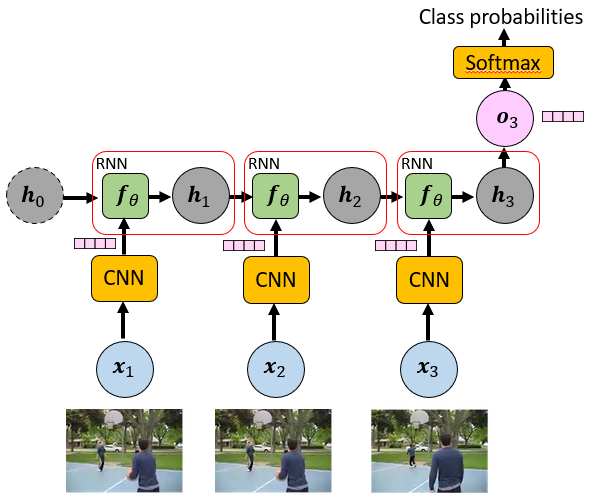

Each frame is passed to a pre-trained, frozen VGG16 encoder. Global Average Pooling (GAP) is applied to the resulting sequence of feature maps, producing a sequence of feature vectors. The sequence is passed to a many-to-one LSTM, followed by a dense network with softmax activation for the final class probabilities 

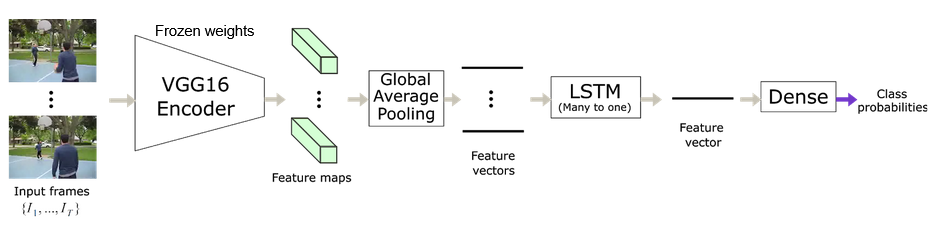

## **<center>VGG Encoder</center>**

The VGG16 encoder is used with ImageNet pre-trained weights.

The encoder is **indepentently** applied to **each frame** in the input video.

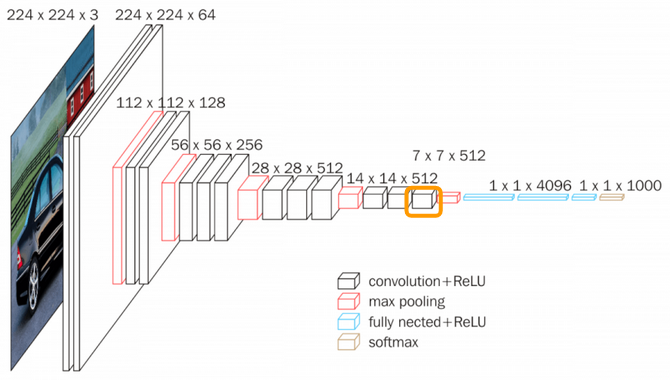

## **<center>Global average pooling (GAP)</center>**

The encoder output is passed to a GAP layer. It obtains the spatial global average value for each channel in the feature map.

GAP is **independently applied** to **each feature map** in the sequence.

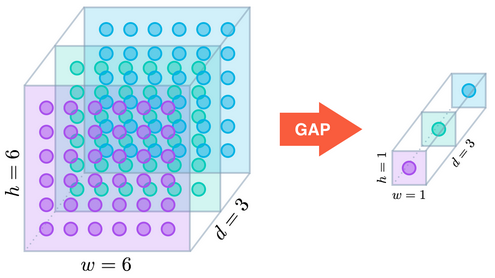

## **<center>Many-to-one LSTM (N-to-1)</center>**

The sequence of feature vectors is passed to a LSTM. We only take the latest element in the resulting sequence. Then we apply a Dense layer with softmax activation function for the final class probabilities 

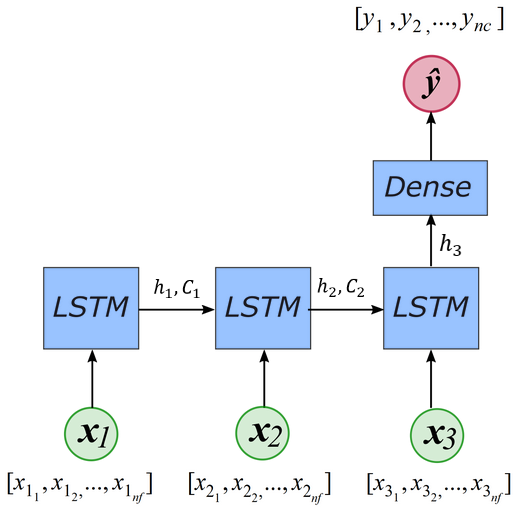

In [1]:
!pip install scikit-video
!pip install icecream
!pip install -q git+https://github.com/tensorflow/docs
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Input
from keras.models import Model
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
from keras import Model
import tensorflow as tf
import skvideo.io
import skvideo.datasets
import glob
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import imageio
from tensorflow_docs.vis import embed
import cv2
import os
%matplotlib inline
import pathlib
import pdb
np.random.seed(7) # fix random seed for reproducibility
import tensorflow
tensorflow.random.set_seed(3)
t0 = time.time()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **<center>Dataset loading and preprocessing</center>**

We will be using the UCF101 action recognition dataset. 4 classes were selected: Basketball, Diving, GolfSwing, Skiing

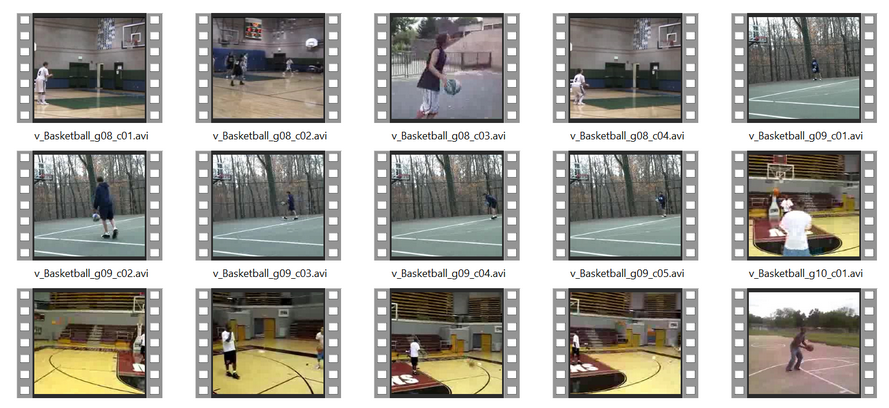

## **<center>Download the videos</center>**



In [4]:
t0=time.time()
os.getcwd()

path = '/content/gdrive/My Drive/RNN_exercise'
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
os.chdir(path)

# Download the videos
!gdown --i 1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
!unzip -n /content/gdrive/My\ Drive/RNN_exercise/Videos.zip -d .

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
To: /content/gdrive/My Drive/RNN_exercise/Videos.zip
100% 208M/208M [00:01<00:00, 122MB/s]
Archive:  /content/gdrive/My Drive/RNN_exercise/Videos.zip


In [5]:
!ls
!ls Videos/Testing
!ls Videos/Training

animation.gif  best_model.h5  pretrained_features.npz  Videos  Videos.zip
Basketball  Diving  GolfSwing  Skiing
Basketball  Diving  GolfSwing  Skiing


## **<center>Prepare the dataset</center>**
* Train test split
* Define the frame number = 40
* Convert labels to one-hot encoding



In [6]:

# This function assigns the corresponding class labels to each sample
def dataset_build(data_path, classes, set_):

  set_file_count=len(glob.glob(data_path+set_+'/**/*.avi',recursive=True))
  print(set_+" file count:",set_file_count)
  X_filenames=[]
  Y=np.zeros(set_file_count)
  sample_id=0

  for clss_name,clss_idx in zip(classes,range(len(classes))):
    clss_file_list=glob.glob(data_path+set_+'/'+clss_name+'/*.avi')
    X_filenames+=clss_file_list
    print("debug: sample_id={}, len(clss_file_list)={}".format(sample_id,clss_file_list))
    Y[sample_id:sample_id+len(clss_file_list)]=clss_idx # Assing labels to samples from each class
    sample_id+=len(clss_file_list)
  return X_filenames, Y

data_path='Videos/'
classes=['Basketball','Diving','GolfSwing','Skiing']
t_len, feature_len, class_n = 40, 512, len(classes)
X_filenames_train,Y_train=dataset_build(data_path, classes, set_='Testing')
X_filenames_test,Y_test=dataset_build(data_path, classes, set_='Training')

print("Train class unique values",np.unique(Y_train,return_counts=True))
print("Test class unique values",np.unique(Y_test,return_counts=True))
print("Classes:",classes)

# Set labels to one-hot 
Y_train=np_utils.to_categorical(Y_train)
Y_test=np_utils.to_categorical(Y_test)

Testing file count: 159
debug: sample_id=0, len(clss_file_list)=['Videos/Testing/Basketball/v_Basketball_g01_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c07.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c04.avi', 'Videos/Testing/B

# **<center>Define the pre-trained model and extract features</center>**


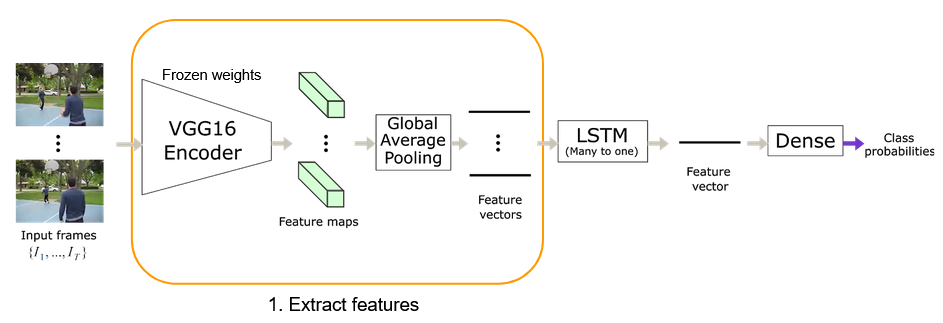

## Specify the pre-trained encoder architecture

In [7]:
def get_model():
    return tf.keras.applications.vgg16.VGG16(include_top=False,weights="imagenet", pooling="avg")  

def extract_features(video_path, model, num_frames=40):

    '''
    1. Loads a video as videogen 
    2. Extracts features from VGG16 CNN encoder model for each frame in vgg16_feature

    Arguments

    video_path: path to the video file.
    model: VGG16 CNN encoder model.
    num_frames: number of frames in the video. Each video has 40 frames.

    Return value

    Returned value is of shape (t_len, feature_len)
    '''
    # Load the video
    if video_path is None:
        video_path = skvideo.datasets.bigbuckbunny()
    videogen = skvideo.io.vreader(video_path)
    vgg16_feature = []

    # Extract features for each frame
    for i in range(num_frames):
        # print(frame.shape)
        frame_crop = next(videogen)[:224,:224]
        
        img_data = np.expand_dims(frame_crop, axis=0)
        img_data = preprocess_input(img_data) # Covert from RGB to BGR. Then subtract ImageNet mean value

        vgg16_feature.append(model.predict(img_data))

    return np.squeeze(np.array(vgg16_feature))

In [8]:
cnnModel = get_model()

58900480/58889256 [==============================] - 0s 0us/step


## Extract features from the pre-trained model

In [9]:
def extract_features_from_set(cnnModel, X_filenames, X):
  # Extract features for each video filename
  # X should be of shape (sample_id, t_len, feature_len)

  X = [extract_features(filename,cnnModel) for filename in X_filenames]

  return np.array(X)

load_pretrained_features_flag = True
pretrained_features_filename = path + '/pretrained_features.npz'

if load_pretrained_features_flag == False:

  X_train = np.zeros((Y_train.shape[0],t_len,feature_len))
  X_test = np.zeros((Y_test.shape[0],t_len,feature_len))
  print("X train shape:{}, X test shape:{}".format(X_train.shape,X_test.shape))

  print("Before extract features execution time: ",time.time()-t0)

  X_train = extract_features_from_set(cnnModel, X_filenames_train, X_train)
  print("Train features extracted")
  print(X_train.shape,X_test.shape)
  X_test = extract_features_from_set(cnnModel, X_filenames_test, X_test)
  print("Test features extracted")

  # Save extracted CNN features
  np.savez(pretrained_features_filename, x_test = X_test, x_train = X_train)

else:
  # CNN feature extraction takes about 25 minutes. 
  # After extracting for the first time, load the CNN features from file
  data = np.load(pretrained_features_filename)

  X_train = data['x_train']
  X_test = data['x_test']

print("X_train.shape={}, Y_train.shape={}".format(X_train.shape,Y_train.shape))
print("X_test.shape={}, Y_test.shape={}".format(X_test.shape,Y_test.shape))

X_train.shape=(159, 40, 512), Y_train.shape=(159, 4)
X_test.shape=(399, 40, 512), Y_test.shape=(399, 4)


# **<center>Define the trainable LSTM model</center>**
Define the LSTM block, and the final Dense layer with softmax. Also, define the training loss and optimizer

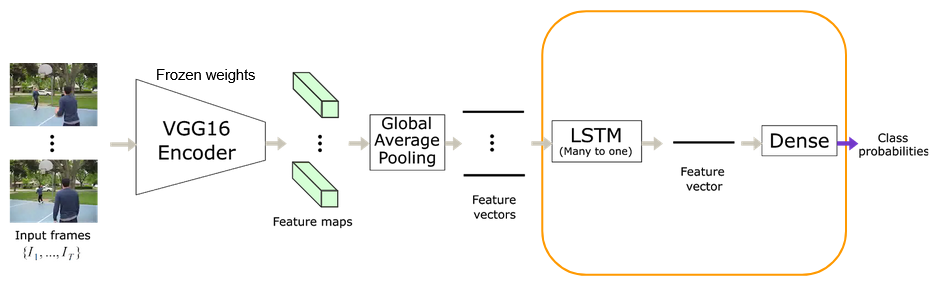

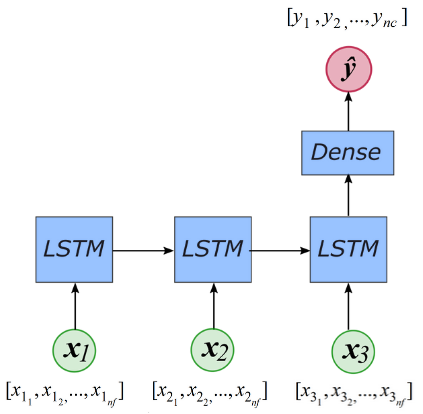

In [10]:
def network(rnn="LSTM", units=100, deep=False, input_shape = (40,512),summary=True):

  model = Sequential()
    
  if rnn =="LSTM":
      if deep:
        model.add(LSTM(units,input_shape=input_shape, return_sequences = True))

      model.add(LSTM(units,input_shape=input_shape))

  elif rnn=="GRU":
    
      model.add(GRU(units,input_shape=input_shape))

  model.add(Dense(64,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(4,activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  loss = CategoricalCrossentropy()

  model.compile(optimizer="adam", loss=loss, metrics=['accuracy'])

  if summary:  
    print("Input shape: ({}, {})".format(input_shape[0],input_shape[1]))
    model.summary()
    print("Before fit execution time: ",time.time()-t0)

  return model

# **<center>Train</center>** 

In [11]:
# Use early stopping.
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, min_delta=0.001)
checkpointer = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# train LSTM 
batch_size = 25
model = network(rnn="LSTM")
model.fit(X_train, Y_train, epochs=1000, batch_size=batch_size, validation_split = 0.1, verbose=2, callbacks=[earlystopping,checkpointer])

Input shape: (40, 512)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               245200    
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 251,924
Trainable params: 251,924
Non-trainable params: 0
_________________________________________________________________
Before fit execution time:  11.847012281417847
Epoch 1/1000
6/6 - 9s - loss: 1.2124 - accuracy: 0.4755 - val_loss: 1.1720 - val_accuracy: 0.6875 - 9s/epoch - 1


# **<center>Evaluate the model</center>**
Predict and estimate test set accuracy (accuracy_score)

In [41]:
# Make predictions on test data (X_test)
# Obtain test set metrics: Overall accuracy, per-class F1 score, average F1 score

def network_predict(network,X_test):

    probabilities = network.predict(X_test)

    Y_pred = np.argmax(probabilities, axis=1)

    Y_hot = np.zeros((Y_pred.size, 4))

    Y_hot[np.arange(Y_pred.size), Y_pred] = 1

    return Y_hot

def metrics(y_true, predicted):

    overall_accuracy = accuracy_score(y_true, predicted)*100
    per_class_f1score = f1_score(y_true, predicted, average=None)*100
    avg_f1score = per_class_f1score.mean()

    return overall_accuracy, per_class_f1score, avg_f1score

In [13]:
pred = network_predict(model, X_test)

overall_accuracy, per_class_f1score, avg_f1score = metrics(Y_test, pred)

print("overall_accuracy | ", "per_class_f1score | ", "avg_f1score ")
print(overall_accuracy, per_class_f1score, avg_f1score)

overall_accuracy |  per_class_f1score |  avg_f1score 
92.4812030075188 [85.39325843 95.77464789 90.32258065 97.89473684] 92.4812030075188


## **<center>Sample test predictions</center>**
Plot test predictions for the final model

(143, 224, 224, 3)
Classification result for video ID 175: Diving



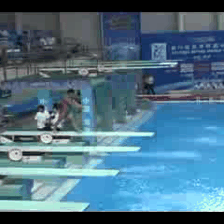

In [14]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


idx = np.random.randint(0, X_test.shape[0]) # Random ID from test set
sample_video = load_video(X_filenames_test[idx])

print(sample_video.shape)
sample_video = sample_video[:100]

# Make prediction on sample test video
prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
prediction = np.squeeze(prediction)

print("Classification result for video ID {}: {}".format(idx, classes[prediction.argmax(axis=0)]))


# Display sample test video
to_gif(sample_video)

In [15]:
print(time.time() - t0)

28.474575757980347


# **<center>Experiments</center>**

1. Use different LSTM internal units: 50, 100, 200, 500
2. Replace LSTM with GRU (count number of parameters)
3. Use a deep LSTM. Two stacked LSTM layers: The output of the first LSTM goes to the input of the second LSTM (Hint: The first LSTM should be configured as "N-to-N" using the parameter "return_sequences")

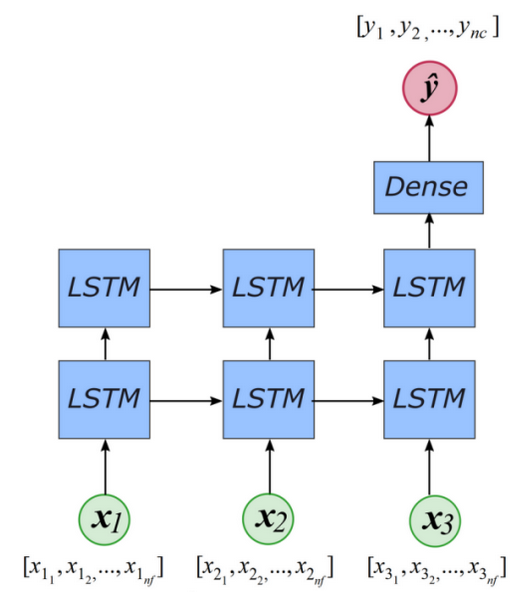

# Report

Homework report: The report must contain:

1.    A link to the notebook with your code.
2.    A PDF file reporting your experiments, including the results in the form of the table, and discussing the results

Fill in your results in the following information in a table.

In [42]:
import pandas as pd

deep = False 

rnn_networks = ["LSTM", "GRU", "Deep LSTM"]
internal_units = [50,100,200,500]

index = pd.MultiIndex.from_product([rnn_networks,internal_units], names=["RNN network","Internal Units",])
experiments = pd.DataFrame(columns=["Overall Accuracy","F1 Class 0", "F1 Class 1","F1 Class 2","F1 Class 3","Avg F1"],index=index)

for config in experiments.index:

  cur_model = config[0] #rnn network
  cur_units = config[1] #internal units

  if "Deep" in cur_model:
     cur_model = "LSTM"
     deep = True

  # train
  model = network(rnn=cur_model, units=cur_units, deep=deep,summary=False)
  model.fit(X_train, Y_train, epochs=1000, batch_size=batch_size, validation_split = 0.1, verbose=0, callbacks=[earlystopping,checkpointer])
  
  # test and metrics
  pred = network_predict(model, X_test)
  overall_accuracy, per_class_f1score, avg_f1score  = metrics(Y_test, pred)

  # save
  experiments.loc[config,:] = [overall_accuracy] + list(per_class_f1score) + [avg_f1score]
  

display(experiments)

Overall Accuracy F1 Class 0 F1 Class 1 F1 Class 2  \
RNN network Internal Units                                                     
LSTM        50                    92.230576  85.128205  94.930876  93.401015   
            100                   94.486216   89.72973  96.330275  95.049505   
            200                   94.987469   90.15544  94.977169  96.482412   
            500                   93.233083  85.714286  93.333333  94.581281   
GRU         50                    90.977444  82.417582  91.743119  93.719807   
            100                   94.486216  89.361702  94.392523  96.039604   
            200                   92.230576  84.269663  94.009217  92.890995   
            500                   92.982456  86.772487  92.592593  96.039604   
Deep LSTM   50                    92.230576  85.436893  92.079208  92.537313   
            100                    90.47619  83.243243  91.428571  91.262136   
            200                   94.235589  89.340102  96.713615  93.401015   
            500                   76.190476  67.169811  91.150442   70.12987   

                           F1 Class 3     Avg F1  
RNN network Internal Units                        
LSTM        50              95.238095  92.174548  
            100             96.373057  94.370642  
            200             98.395722  95.002686  
            500              98.93617  93.141268  
GRU         50              95.287958  90.792117  
            100             97.938144  94.432993  
            200                96.875  92.011219  
            500             96.335079   92.93494  
Deep LSTM   50              99.470899  92.381079  
            100             95.431472  90.341356  
            200             97.382199  94.209233  
            500             75.816993  76.066779

## Gráficos

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1,cols=3,subplot_titles=experiments.index.levels[0])
fig2 = make_subplots(rows=1,cols=3,subplot_titles=experiments.index.levels[0])
col = 1
legend = True
color = ['blue', 'red', 'green','purple']
for  rnn in experiments.index.levels[0]:

  temp = experiments.loc[rnn]
  fig.add_trace(go.Scatter(x=temp.index,y=temp["Overall Accuracy"],name="Overall Accuracy",marker_color="red",showlegend=legend),row=1,col=col)
  fig.add_trace(go.Scatter(x=temp.index,y=temp["Avg F1"],name="F1 Score",marker_color="blue",showlegend=legend),row=1,col=col)

  for idx,f1_class in enumerate(['F1 Class 0', 'F1 Class 1', 'F1 Class 2','F1 Class 3']):

    fig2.add_trace(go.Scatter(x=temp.index,y=temp[f1_class],name=f1_class,showlegend=legend,marker_color=color[idx]),row=1,col=col)

  col += 1

  legend = False

fig.update_xaxes(title="Internal Units")
fig.update_layout(title=f"<b>RNN Comparison x Internal Units</b>")
fig.show()

fig2.update_xaxes(title="Internal Units")
fig2.show()